**If you think this notebook deserves an upvote, I'd love to have it. An upvote per view, its all I ask**
(credit to [Dan Carlin](https://twitter.com/HardcoreHistory) for coining the phrase ;-) 

---------------------------------------

This is part of a series of notebooks about practical time series methods:

* [Part 0: the basics](https://www.kaggle.com/konradb/ts-0-the-basics)
* [Part 1a: smoothing methods](https://www.kaggle.com/konradb/ts-1a-smoothing-methods)
* [Part 1b: Prophet](https://www.kaggle.com/konradb/ts-1b-prophet) 
* [Part 2: ARMA](https://www.kaggle.com/konradb/ts-2-arma-and-friends)
* [Part 3: Time series for finance](https://www.kaggle.com/konradb/ts-3-time-series-for-finance) 
* [Part 4: Sales and demand forecasting](https://www.kaggle.com/konradb/ts-4-sales-and-demand-forecasting)
* [Part 5: Automatic for the people](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people) 
* [Part 6: Deep learning for TS - sequences](https://www.kaggle.com/konradb/ts-6-deep-learning-for-ts-sequences)
* [Part 7: Survival analysis](https://www.kaggle.com/konradb/ts-7-survival-analysis)
* [Part 8: Hierarchical time series](https://www.kaggle.com/konradb/ts-8-hierarchical-time-series) 
* [Part 9: Hybrid methods](https://www.kaggle.com/konradb/ts-9-hybrid-methods) 
* [Part 10: Validation methods for time series](https://www.kaggle.com/konradb/ts-10-validation-methods-for-time-series) - **this notebook**
* [Part 11: Transfer learning](https://www.kaggle.com/code/konradb/ts-11-deep-learning-for-ts-transfer-learning)


The series is accompanied by video presentations on the YouTube channel of [Abhishek](https://www.kaggle.com/abhishek):

* [Talk 0](https://www.youtube.com/watch?v=cKzXOOtOXYY) 
* [Talk 1](https://www.youtube.com/watch?v=kAI67Sz92-s) - combining the content from parts 1a and 1b
* [Talk 2](https://www.youtube.com/watch?v=LjV5DE3KR-U) 
* [Talk 3](https://www.youtube.com/watch?v=74rDhJexmTg)
* [Talk 4](https://www.youtube.com/watch?v=RdH8zd07u2E) 
* [Talk 5](https://www.youtube.com/watch?v=wBP8Pc4Wxzs) 
* [Talk 6](https://www.youtube.com/watch?v=81AEI0tj0Kk) 
* [Talk 7](https://www.youtube.com/watch?v=m-8I_hkmz9o)
* [Talk 8](https://www.youtube.com/watch?v=7ZTarg4QYR4)
* [Talk 9](https://www.youtube.com/watch?v=NYZzBvKcfp4)
* [Talk 10](https://www.youtube.com/watch?v=47WeBiLV2Uo) - **based on this notebook**
* [Talk 11]()


---------------------------------------

With the exception of people who deploy to production on a Friday evening because YOLO, we all agree that model validation matters: measuring the performance of an ML model (and hence its generalisation power) allows us to assess the robustness, optimise parameters and estimate performance on unseen data. If there is a good reason to believe the underlying data generating process is stationary (no concept drift), you are usually fine with training-validation-test split (overfitting to validation set notwithstanding). It becomes slightly more complicated if the temporal dimension matters: in this episode we will walk through different manners of assessing performance of time series models without breaking the arrow of time.


* [Random split](#section-one)
* [KFold](#section-two)
* [Walk forward](#section-three)
* [Group Time Series](#section-four)
* [Purged Group KFold](#section-five)
* [Combinatorial Purged Group KFold](#section-six)


In [ ]:
import os
from IPython.display import Image
import pandas as pd
import numpy as np
import lightgbm as lgb
import gc

from scipy.stats import pearsonr as p

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') 

import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
# general settings
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10
    seed = 13
    nfolds = 5
    nof_trees = 150
    cutoff_point = 1100
    
# adjust the parameters for displayed figures    
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})   

In [ ]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

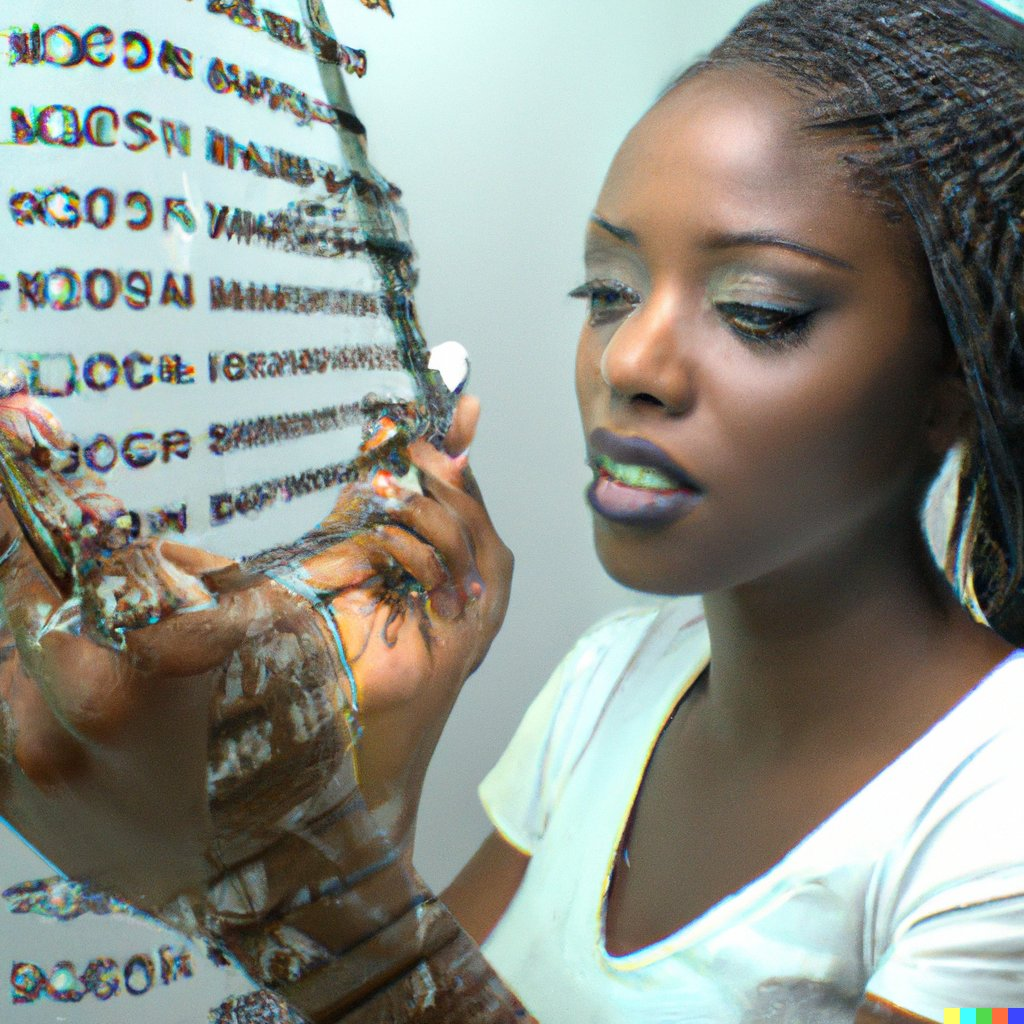

<a id="section-one"></a>
# Random split

We will be using data from the recently ended Ubiquant Market Prediction competition: https://www.kaggle.com/competitions/ubiquant-market-prediction. 

In [ ]:
xtrain = pd.read_parquet("../input/ubiquant-parquet/train_low_mem.parquet")
xtrain.head(10)

The problem had quite a few characteristics that made it a little more challenging than usual:

- multiple investments - not all of them present at each timestamp

- (potentially) different spacing between timestamps

- test observations not taken *immediately* after the test period


In [ ]:
xtrain['time_id'].min(), xtrain['time_id'].max()

**PSA: to make the setup really proper, we should have a loop around this block and change the test set as well**   $\rightarrow$ otherwise we run a risk of overfitting to the test set




We will keep the observations from timestamp 1100 onward as our holdout test set and play around with the rest:

In [ ]:
# train / validation split
xtest = xtrain.loc[xtrain.time_id > CFG.cutoff_point].copy()
xtrain = xtrain.loc[xtrain.time_id <= CFG.cutoff_point].copy()
print(xtrain.shape, xtest.shape)

In [ ]:
# normal cleanup and preparation

id_train, id_test = xtrain['row_id'].copy(), xtest['row_id'].copy()
xtrain.drop('row_id', axis = 1, inplace = True)
xtest.drop('row_id', axis = 1, inplace = True)

ytrain, ytest = xtrain['target'].copy(), xtest['target'].copy()
inv_train, inv_test = xtrain['investment_id'].copy(), xtest['investment_id'].copy()
time_train, time_test = xtrain['time_id'].copy(), xtest['time_id'].copy()

xtrain.drop(['time_id', 'investment_id', 'target'], axis = 1, inplace = True)
xtest.drop(['time_id', 'investment_id', 'target'], axis = 1, inplace = True)

xtrain = reduce_mem_usage(xtrain)
xtest = reduce_mem_usage(xtest)

gc.collect()

Given the structure of the data, we will forego the sequence-based approaches and reduce the prediction to an ML problem (along the lines of what we did in [Episode 4](https://www.kaggle.com/code/konradb/ts-4-sales-and-demand-forecasting)). First validation setup is a random split - for obvious reasons we do not expect success, but it is useful to keep as a reference / baseline:

In [ ]:
from sklearn.model_selection import train_test_split


x0, x1, y0, y1 = train_test_split(xtrain, ytrain, test_size=0.33, random_state=42)

In [ ]:
lgb_parameters = {'objective': 'regression', 'metric': 'rmse', 'num_iterations': CFG.nof_trees, 
                          'num_leaves': 32, 'learning_rate': 0.1, 'subsample': 0.8, 'colsample_bytree': 0.6}

model = lgb.LGBMRegressor(**lgb_parameters)


model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)], verbose= 250, early_stopping_rounds=100)
val_preds = model.predict(x1)

In [ ]:
# validation score    
score = np.round(p(val_preds, y1)[0],4)
print("validation score: " + str(score))


# actual test performance
test_preds = model.predict(xtest)
score = np.round(p(test_preds, ytest)[0],4)
print("test score: " + str(score))


del x0, x1, y0, y1; gc.collect()

Not very surprisingly, there is a massive gap: our series are serially correlated, so by using random sampling we are leaking information (the model is trained on future observations and then "predicts" the past).
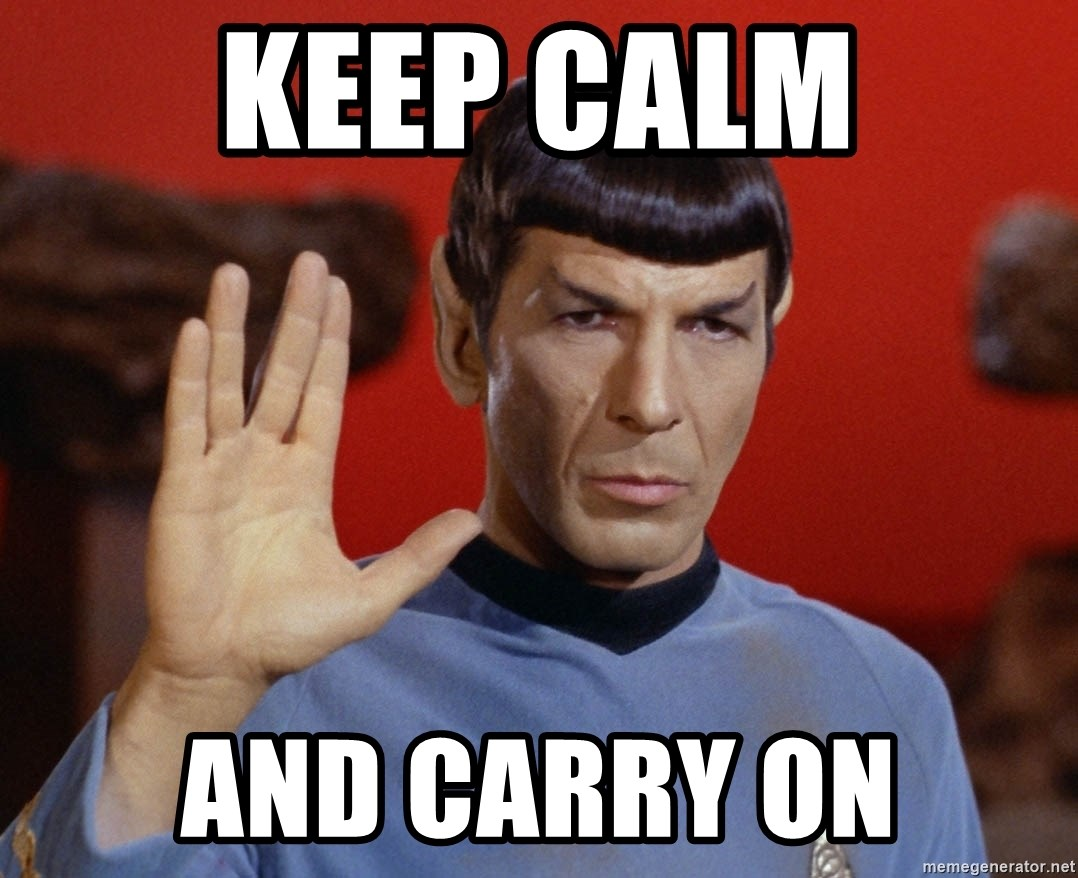



<a id="section-two"></a>
# KFold

A second most common approach to validation is `KFold`:

[Source](https://scikit-learn.org/stable/modules/cross_validation.html)

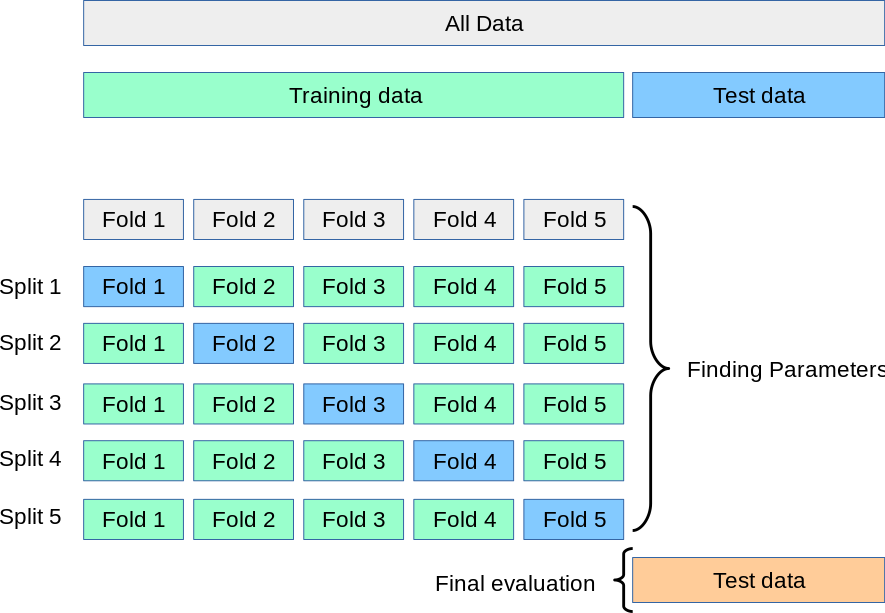

The issues mentioned for random split are valid for KFold as well:

- test data occurs before training data

- gaps in the training series (windows 2–4)


[Source](https://towardsdatascience.com/dont-use-k-fold-validation-for-time-series-forecasting-30b724aaea64)

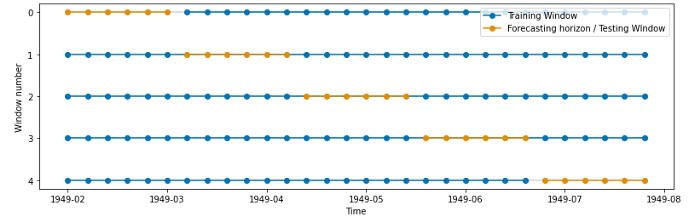

However, [Bergmeir et al](https://robjhyndman.com/publications/cv-time-series/) make the case that it does work autoregressions, i.e. series where the predictors are lagged values of the response variable. Since the features were anonymised, we cannot decide a priori whether this is the right approach. Instead, we will find out empirically:



In [ ]:
from sklearn.model_selection import KFold

kf = KFold(n_splits = CFG.nfolds,  shuffle = True, random_state = CFG.seed)
res_vec = np.zeros((CFG.nfolds, 1))


prv = np.zeros((xtest.shape[0],CFG.nfolds))

for (ii, (id0, id1)) in enumerate(kf.split(xtrain)):
    
    print('fold: ' + str(ii))
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)], verbose= 250, early_stopping_rounds=100)
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1

In [ ]:
avg_score = np.round(np.mean(res_vec),4)
print("average score across folds: " + str(avg_score))
score = np.round(p(ytest, prv.mean(axis = 1))[0],4)

print("full test score: " + str(score))

There is still substantial overfit occurring, indicating that whatever the features are, they are not (a proxy for) lagged values of the target variable. What if we tried to do sth more time-series oriented, that took the temporal dependency explicitly into account? There are two changes that come to mind:
- respect the chronological order of the data $\rightarrow$ the training set should occur before the validation set, which should occur before the test set
- the test set should move over time


<a id="section-three"></a>
# Walk forward

The scikit-learn implementation of a time series split (a.k.a walk forward validation) is a variation of `KFold`: 

* in the $k$th split, it returns first $k$ folds as train set and the $(k+1)$th fold as test set

* successive training sets can be supersets of those that came before them or have a fixed size $\rightarrow$ controlled by *max_train_size* argument. 

* useful in time-sensitive contexts like trading $\rightarrow$ robustness of a strategy, concept drift

* backtesting (see [Episode 5](https://www.kaggle.com/code/konradb/ts-5-automatic-for-the-people)) is based around wfv - with / without refitting the model

Let's with a progressively increasing train set:


[Source](https://audhiaprilliant.medium.com/walk-forward-optimization-cross-validation-technique-for-time-series-data-61739f58f2c0)

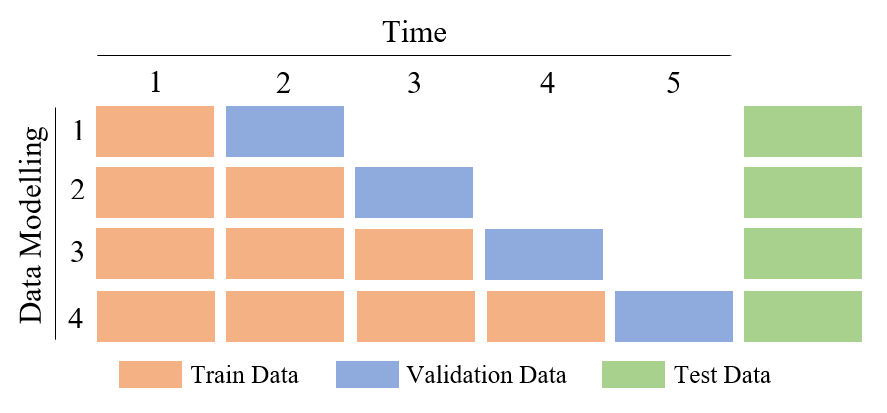

In [ ]:
from sklearn.model_selection import TimeSeriesSplit

tscv = TimeSeriesSplit(n_splits = CFG.nfolds , max_train_size = None)

res_vec = np.zeros((CFG.nfolds, 1))

In [ ]:
for (ii, (id0, id1)) in enumerate(tscv.split(xtrain)):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)], verbose= 250, early_stopping_rounds=100)
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1
    
gc.collect()

What if we limit the size of the training set? 

[Source](https://audhiaprilliant.medium.com/walk-forward-optimization-cross-validation-technique-for-time-series-data-61739f58f2c0)

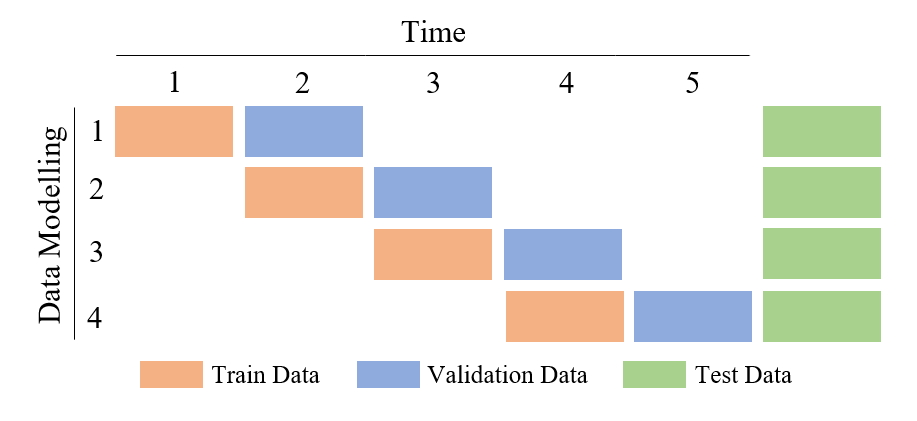

In [ ]:
tscv = TimeSeriesSplit(n_splits = CFG.nfolds , max_train_size = 2 * xtest.shape[0])

res_vec = np.zeros((CFG.nfolds, 1))


for (ii, (id0, id1)) in enumerate(tscv.split(xtrain)):
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)], verbose= 250, early_stopping_rounds=100)
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1

WFV pros: 

- clear historical interpretation 

- history is a [filtration](https://en.wikipedia.org/wiki/Filtration_(probability_theory))

WFV cons:

- one single scenario is tested, which is easily overfit (coming later)

- initial decisions based on smaller portion of the total sample 

- future performance / concept drift $\rightarrow$ not wfv-specific


Both fixed and increasing train set do better than the predecessors, but as usual with these things it helps to look at the details 

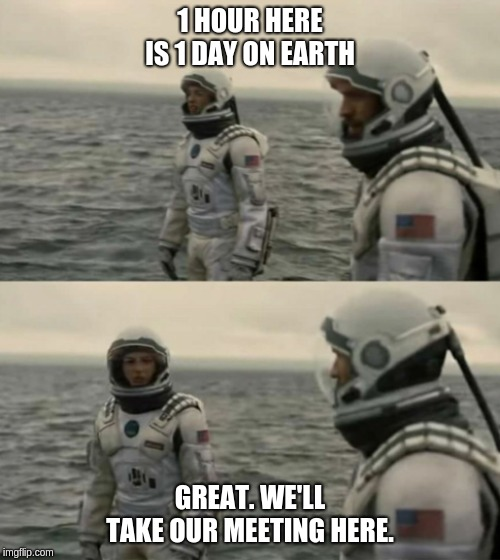 

The very idea of time-based split is that we avoid peeking forward in time 

In [ ]:
for train_idx, test_idx in TimeSeriesSplit().split(xtrain):
    id1 = time_train.loc[train_idx].unique()
    id2 = time_train.loc[test_idx].unique()
    
    print(np.intersect1d(id1,id2))


- First split: day 44 is present in both training and test $\implies$ we are training on half of the trades of a certain day, just to validate their performance on the other half of the trades of that da

- so we have a mostly clean separation, but not quite. can we do better?


<a id="section-four"></a>
# Group Time Series

The story so far: 

- `GroupKFold` iterator does respect groupings: no group will ever be part of two folds **BUT** messes up the temporal order

- `TimeSeriesSplit` is the other way round


In [ ]:
from sklearn.model_selection import GroupKFold

for train_idx, test_idx in GroupKFold().split(xtrain, groups = pd.DataFrame(time_train)['time_id']):
    id1 = time_train.loc[train_idx].unique()
    id2 = time_train.loc[test_idx].unique()
    
    print(id1[0:10])
    print(id2[0:10])
    print(np.intersect1d(id1,id2))

    print('---')
    

What we need is a a crossover between `GroupKFold` and `TimeSeriesSplit`:  enter `GroupTimesSeriesSplit`- and [**Gaurav Chawla**](https://www.kaggle.com/gc2713)
([git](https://github.com/getgaurav2/), [LI](https://www.linkedin.com/in/gauravchawla-columbia)) created just that with `GroupTimeSeriesSplit`- do make sure to check him out!

The notebook from which we borrow the codewas written by [J.J. Smit](https://www.kaggle.com/jorijnsmit):  https://www.kaggle.com/code/jorijnsmit/found-the-holy-grail-grouptimeseriessplit.

In [ ]:
# Taken from the notebo
from sklearn.model_selection._split import _BaseKFold, indexable, _num_samples
from sklearn.utils.validation import _deprecate_positional_args

# https://github.com/getgaurav2/scikit-learn/blob/d4a3af5cc9da3a76f0266932644b884c99724c57/sklearn/model_selection/_split.py#L2243
class GroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_size : int, default=None
        Maximum size for a single training set.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import GroupTimeSeriesSplit
    >>> groups = np.array(['a', 'a', 'a', 'a', 'a', 'a',\
                           'b', 'b', 'b', 'b', 'b',\
                           'c', 'c', 'c', 'c',\
                           'd', 'd', 'd'])
    >>> gtss = GroupTimeSeriesSplit(n_splits=3)
    >>> for train_idx, test_idx in gtss.split(groups, groups=groups):
    ...     print("TRAIN:", train_idx, "TEST:", test_idx)
    ...     print("TRAIN GROUP:", groups[train_idx],\
                  "TEST GROUP:", groups[test_idx])
    TRAIN: [0, 1, 2, 3, 4, 5] TEST: [6, 7, 8, 9, 10]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a']\
    TEST GROUP: ['b' 'b' 'b' 'b' 'b']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10] TEST: [11, 12, 13, 14]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b']\
    TEST GROUP: ['c' 'c' 'c' 'c']
    TRAIN: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]\
    TEST: [15, 16, 17]
    TRAIN GROUP: ['a' 'a' 'a' 'a' 'a' 'a' 'b' 'b' 'b' 'b' 'b' 'c' 'c' 'c' 'c']\
    TEST GROUP: ['d' 'd' 'd']
    """
    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_size=None
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_size = max_train_size

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
        group_test_size = n_groups // n_folds
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []
            for train_group_idx in unique_groups[:group_test_start]:
                train_array_tmp = group_dict[train_group_idx]
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)
            train_end = train_array.size
            if self.max_train_size and self.max_train_size < train_end:
                train_array = train_array[train_end -
                                          self.max_train_size:train_end]
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)
            yield [int(i) for i in train_array], [int(i) for i in test_array]

Let's see how it performs:

In [ ]:
# sanity check
for train_idx, test_idx in GroupTimeSeriesSplit().split(xtrain, groups = pd.DataFrame(time_train)['time_id']):
    id1 = time_train.loc[train_idx].unique()
    id2 = time_train.loc[test_idx].unique()
    
    print(id1[0:25])
    print(id2[0:25])
    print(np.intersect1d(id1,id2))    
    
    print('---')

In [ ]:
res_vec = np.zeros((CFG.nfolds, 1))

for (ii, (id0, id1)) in enumerate(GroupTimeSeriesSplit().split(xtrain, groups = pd.DataFrame(time_train)['time_id'])):
    
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)],
              verbose= 250, early_stopping_rounds=100)
    
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1

In terms of non-financial applications, the above is probably fit for purpose most of the time. Within finance or trading though...

<a id="section-five"></a>
# Purged Group Time Series

As we have seen above, moving to Group Time Series split improves the situation. If we focus on the specific domain of this competition (finance), we can go a step further and make the validation scheme a little closer to the real situation - by exploring the nature of event times in finance:

* a labelled data point in a financial time series has a trade time and an event time.

* event time = when in the future the mark-to-market value of an asset reached a certain level such as a stop loss or a take profit price. 

* this means that labels become path-dependent, and care needs to be taken so that when computing labels we don't peek into the out-of-sample fold.

Excellent example from https://blog.quantinsti.com/cross-validation-embargo-purging-combinatorial/:

For a concrete example, say we are trying to build an ML model to predict whether IBM prices would move up or down in the next 5 business days by at least 50 basis points (bps) based on various data sources. The size of these movements are estimated based on recent levels of realised volatility for IBM shares. A common labelling scheme would be: +1 if the share price moves more than 50 bps, 0 if the share price moves by less than 50 bps in absolute value, and -1 if the share price moves down by more than 50 bps. Next, let's assume that our typical trading horizon is 1 week. You would enter a position today, and liquidate it one week later. Most people in practice however would have a stop loss or take profit level for a trade so that they can exit a trade earlier if either of those levels are reached. The point is that to mark-to-market your trade, you'd need to observe the price path during the next 5 days, or for the next 5 ticks (you could exit before).

TL;DR **In the labelling process, we have to take care to remove data for which the event times overlap with the trade times in the test fold. This process is called purging.**

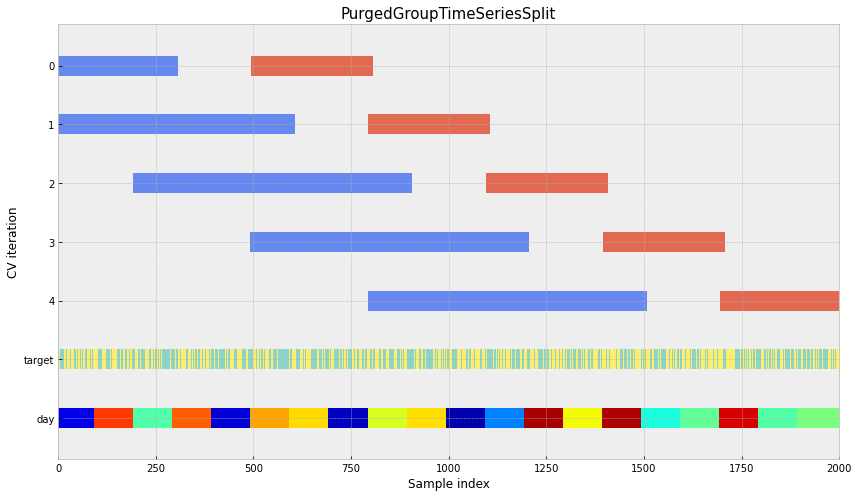

We build on the code from https://www.kaggle.com/code/marketneutral/purged-time-series-cv-xgboost-optuna:

* `GroupTimeSeriesSplit` is the basis 

* we add a `gap` between each train and validation split: the group aspect keeps whole days together, but anonymized features have some kind of lag or window calculations in them (results from our `KFold` section notwithstanding). By introducing a gap, we mitigate the risk that we leak information from train into validation

* we can specify the size of the train and validation splits in terms of number of days.

* the sizes of the train, gap, and valid sets respect the different number of samples per day. 

* you can split the data on number of days in the validation set, number of days gap between, and number of days in the train set.

You can see in the "group" bars that the days are different lengths.

In [ ]:
class PurgedGroupTimeSeriesSplit(_BaseKFold):
    """Time Series cross-validator variant with non-overlapping groups.
    Allows for a gap in groups to avoid potentially leaking info from
    train into test if the model has windowed or lag features.
    Provides train/test indices to split time series data samples
    that are observed at fixed time intervals according to a
    third-party provided group.
    In each split, test indices must be higher than before, and thus shuffling
    in cross validator is inappropriate.
    This cross-validation object is a variation of :class:`KFold`.
    In the kth split, it returns first k folds as train set and the
    (k+1)th fold as test set.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    Note that unlike standard cross-validation methods, successive
    training sets are supersets of those that come before them.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of splits. Must be at least 2.
    max_train_group_size : int, default=Inf
        Maximum group size for a single training set.
    group_gap : int, default=None
        Gap between train and test
    max_test_group_size : int, default=Inf
        We discard this number of groups from the end of each train split
    """

    @_deprecate_positional_args
    def __init__(self,
                 n_splits=5,
                 *,
                 max_train_group_size=np.inf,
                 max_test_group_size=np.inf,
                 group_gap=None,
                 verbose=False
                 ):
        super().__init__(n_splits, shuffle=False, random_state=None)
        self.max_train_group_size = max_train_group_size
        self.group_gap = group_gap
        self.max_test_group_size = max_test_group_size
        self.verbose = verbose

    def split(self, X, y=None, groups=None):
        """Generate indices to split data into training and test set.
        Parameters
        ----------
        X : array-like of shape (n_samples, n_features)
            Training data, where n_samples is the number of samples
            and n_features is the number of features.
        y : array-like of shape (n_samples,)
            Always ignored, exists for compatibility.
        groups : array-like of shape (n_samples,)
            Group labels for the samples used while splitting the dataset into
            train/test set.
        Yields
        ------
        train : ndarray
            The training set indices for that split.
        test : ndarray
            The testing set indices for that split.
        """
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
        X, y, groups = indexable(X, y, groups)
        n_samples = _num_samples(X)
        n_splits = self.n_splits
        group_gap = self.group_gap
        max_test_group_size = self.max_test_group_size
        max_train_group_size = self.max_train_group_size
        n_folds = n_splits + 1
        group_dict = {}
        u, ind = np.unique(groups, return_index=True)
        unique_groups = u[np.argsort(ind)]
        n_samples = _num_samples(X)
        n_groups = _num_samples(unique_groups)
        for idx in np.arange(n_samples):
            if (groups[idx] in group_dict):
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))

        group_test_size = min(n_groups // n_folds, max_test_group_size)
        group_test_starts = range(n_groups - n_splits * group_test_size,
                                  n_groups, group_test_size)
        for group_test_start in group_test_starts:
            train_array = []
            test_array = []

            group_st = max(0, group_test_start - group_gap - max_train_group_size)
            for train_group_idx in unique_groups[group_st:(group_test_start - group_gap)]:
                train_array_tmp = group_dict[train_group_idx]
                
                train_array = np.sort(np.unique(
                                      np.concatenate((train_array,
                                                      train_array_tmp)),
                                      axis=None), axis=None)

            train_end = train_array.size
 
            for test_group_idx in unique_groups[group_test_start:
                                                group_test_start +
                                                group_test_size]:
                test_array_tmp = group_dict[test_group_idx]
                test_array = np.sort(np.unique(
                                              np.concatenate((test_array,
                                                              test_array_tmp)),
                                     axis=None), axis=None)

            test_array  = test_array[group_gap:]
            
            
            if self.verbose > 0:
                    pass
                    
            yield [int(i) for i in train_array], [int(i) for i in test_array]

In [ ]:
cv = PurgedGroupTimeSeriesSplit( n_splits=5,
    max_train_group_size=15, group_gap=5, max_test_group_size=5)

In [ ]:
res_vec = np.zeros((CFG.nfolds, 1))

for (ii, (id0, id1)) in enumerate(cv.split(xtrain, groups = pd.DataFrame(time_train)['time_id'])):
    
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)],
              verbose= 250, early_stopping_rounds=100)
    
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1

As you can see from the performance, sometimes a purge is a good idea.

<a id="section-six"></a>
# Combinatorial purged group KFold

While the approaches demonstrated above differ in several aspects, they share one characteristic: each of them only tests a single path $\rightarrow$ no counterfactuals possible; 
a single backtest path is simulated $\rightarrow$ one and only one forecast is generated per observation. 

Alternative approach: some combinatorial tricks to **generate multiple backtest paths**.


How does it work in practice https://towardsai.net/p/l/the-combinatorial-purged-cross-validation-method4



CPCV provides the exact number of combinations of training/testing sets required to construct a set of backtesting paths while purging training observations that contain leaked information, given a set of backtest paths targeted by the researcher.

First, we have our data, say 1000 data points. Imagine we want to split those 1000 datapoints into 6 groups. Of these 6 groups, we want 2 test groups (figure below).



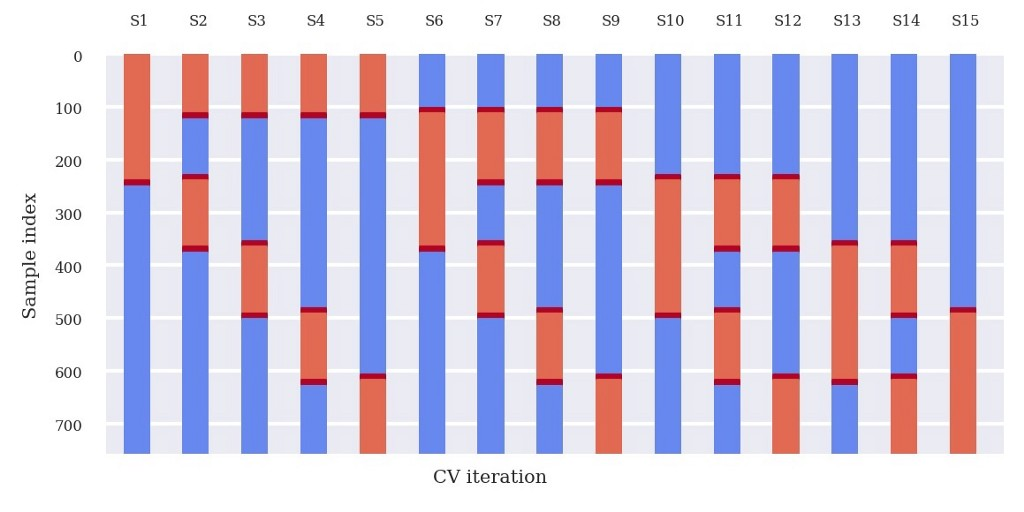



How many data splits are possible? 

\begin{equation}
\binom{6}{6-2}= 15
\end{equation}

Every split involves k=2 tested groups, which means that the total amount of testing groups is k * N_splits, which is 30. Moreover, since we have computed all possible combinations, these tested groups are uniformly distributed across all N. Therefore, there is a total number of paths 30 / 6= 5 paths.


Figure 1 indicates the groups that make up the testing set with an x and leaves the groups that make up the training set unmarked for each split. This train/test split technique allows us to compute 5 backtest pathways because each group is a member of $\phi$[6, 2] = 5 testing sets.


For a detailed description 


We take the implementation from https://www.kaggle.com/code/gogo827jz/combinatorial-purged-group-k-fold:

In [ ]:
import numpy as np
from scipy.special import comb
from itertools import combinations

class CombinatorialPurgedGroupKFold():
    def __init__(self, n_splits = 6, n_test_splits = 2, purge = 1, pctEmbargo = 0.01, **kwargs):
        self.n_splits = n_splits
        self.n_test_splits = n_test_splits
        self.purge = purge
        self.pctEmbargo = pctEmbargo
        
    def split(self, X, y = None, groups = None):
        if groups is None:
            raise ValueError(
                "The 'groups' parameter should not be None")
            
        u, ind = np.unique(groups, return_index = True)
        unique_groups = u[np.argsort(ind)]
        n_groups = len(unique_groups)
        group_dict = {}
        for idx in range(len(X)):
            if groups[idx] in group_dict:
                group_dict[groups[idx]].append(idx)
            else:
                group_dict[groups[idx]] = [idx]
                
        n_folds = comb(self.n_splits, self.n_test_splits, exact = True)
        if n_folds > n_groups:
            raise ValueError(
                ("Cannot have number of folds={0} greater than"
                 " the number of groups={1}").format(n_folds,
                                                     n_groups))
            
        mbrg = int(n_groups * self.pctEmbargo)
        if mbrg < 0:
            raise ValueError(
                "The number of 'embargoed' groups should not be negative")
        
        split_dict = {}
        group_test_size = n_groups // self.n_splits
        for split in range(self.n_splits):
            if split == self.n_splits - 1:
                split_dict[split] = unique_groups[int(split * group_test_size):].tolist()
            else:
                split_dict[split] = unique_groups[int(split * group_test_size):int((split + 1) * group_test_size)].tolist()
        
        for test_splits in combinations(range(self.n_splits), self.n_test_splits):
            test_groups = []
            banned_groups = []
            for split in test_splits:
                test_groups += split_dict[split]
                banned_groups += unique_groups[split_dict[split][0] - self.purge:split_dict[split][0]].tolist()
                banned_groups += unique_groups[split_dict[split][-1] + 1:split_dict[split][-1] + self.purge + mbrg + 1].tolist()
            train_groups = [i for i in unique_groups if (i not in banned_groups) and (i not in test_groups)]

            train_idx = []
            test_idx = []
            for train_group in train_groups:
                train_idx += group_dict[train_group]
            for test_group in test_groups:
                test_idx += group_dict[test_group]
            yield train_idx, test_idx

What really happens? Let's test on a toy dataset:

In [ ]:
n_splits = 6
n_test_splits = 1
elements = list(range(10 * (n_splits + n_test_splits)))
groups = [element // n_splits for element in elements]
data = pd.DataFrame({"group": groups, "element": elements})
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)
for index, (train_indices, test_indices) in enumerate(kfold.split(data, groups=data["group"])):
    print("=" * 100)
    print(f"Fold {index}")
    print("=" * 100)
    print("Train indices:", train_indices, "Length:", len(train_indices))
    print("Test Indices:", test_indices, "Length:", len(test_indices))

Moving on to complete data:

In [ ]:
n_splits = 5
n_test_splits = 1
kfold = CombinatorialPurgedGroupKFold(n_splits, n_test_splits)

for (ii, (id0, id1)) in enumerate(kfold.split(xtrain, groups = pd.DataFrame(time_train)['time_id'])):
    
    x0, x1 = xtrain.loc[id0], xtrain.loc[id1]
    y0, y1 = ytrain.loc[id0], ytrain.loc[id1]
    
    
    model = lgb.LGBMRegressor(**lgb_parameters)

    model.fit(x0, y0, eval_metric='rmse', eval_set=[(x0, y0), (x1, y1)],
              verbose= 250, early_stopping_rounds=100)
    
    val_preds = model.predict(x1)
    prv[:,ii] += model.predict(xtest) / CFG.nfolds
    
    # validation score    
    score = np.round(p(val_preds, y1)[0],4)
    res_vec[ii] = score
    print("validation score: " + str(score))

    # actual test performance
    test_preds = model.predict(xtest)
    score = np.round(p(test_preds, ytest)[0],4)
    print("test score: " + str(score))


    del model, x0, x1, y0, y1

This concludes our tour of time series validation techniques.

Recommended reading: https://www.arxiv-vanity.com/papers/2203.10716/